In [1]:
import numpy as np
from scipy import sparse
from sklearn import svm
import pandas as pd
import pickle
from keras.layers import Dense
from keras.models import Sequential
import keras
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import to_categorical
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
inspire = pd.read_pickle('REFS_')
insipre = inspire.reindex(np.random.permutation(inspire.index))
inspire = inspire.reset_index(drop=True)
inspire.head()

,Text,core refs,non-core refs,Category,Result
0,Comparing Robustness of Pairwise and Multiclas...,0.000000,0.000000,cs.AI,0
1,On an Auxiliary Function for Log-Density Estim...,0.000000,0.000000,stat.CO,0
2,The two defaults scenario for stressing credit...,0.000000,0.000000,q-fin.RM,0
3,Coulomb drag as a measure of trigonal warping ...,0.051282,0.179487,cond-mat.mes-hall,0
4,Dissipative Hofstadter Model at the Magic Poin...,0.647059,0.176471,hep-th,2


In [3]:
# tokenise text for later
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(inspire['Text'])
sequences = tokenizer.texts_to_sequences(inspire['Text'])
data = pad_sequences(sequences, maxlen=500)

In [5]:
# SPLIT DATA INTO TRAIN/ TEST
training_samples = 14 * len(inspire) // 20
validation_samples = 3 * len(inspire) // 10

train = data[:training_samples]
val = data[training_samples:training_samples + validation_samples]
test = data[training_samples + validation_samples:]

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples].reset_index(drop=True)
inspire_test = inspire[training_samples + validation_samples:].reset_index(drop=True)

In [6]:
# FIND WEIGHTS FOR LATER
N_core =    len( inspire_train['Result'][ inspire_train['Result'] == 2 ] )
N_noncore = len( inspire_train['Result'][ inspire_train['Result'] == 1 ] )
N_rej  =    len( inspire_train['Result'][ inspire_train['Result'] == 0 ] )

print (N_core, N_noncore, N_rej)

N_total = float(len(inspire_train['Result']))
weights = {0: N_total/(N_core),
          1: N_total/(N_noncore),
           
          2: N_total/(N_rej)}
print (weights)

(5361, 2963, 27891)
{0: 6.755269539265062, 1: 12.2224097198785, 2: 1.2984475278763759}


## net 

here, I want to make a neurel net, train it for the text, syphon of the auxiliary layer and put it into an SVM with the reference data

In [7]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

main_input = Input(shape=(500,), dtype='float', name='main_input')
x = Embedding(output_dim=100, input_dim=10000, input_length = 500)(main_input)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
auxiliary_output = Dense(32, activation='sigmoid', name='aux_output')(x)

main_output = Dense(3, activation='softmax', name='main_output')(x)

model = Model(inputs=[main_input], outputs=[main_output, auxiliary_output])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [8]:
history = model.fit({'main_input': train}, 
                    {'main_output': inspire_train['Result'], 'aux_output': inspire_train['Result']}, 
                    epochs=7, batch_size=300, class_weight=weights,
                    validation_data=({'main_input':val},
                                     {'main_output': inspire_val['Result'],'aux_output': inspire_val['Result']}))

Train on 36215 samples, validate on 15520 samples
Epoch 1/7
36215/36215 [==============================] - 15s 424us/step - loss: 1.6199 - main_output_loss: 0.5430 - aux_output_loss: 1.0769 - main_output_acc: 0.8166 - aux_output_acc: 0.7187 - val_loss: 0.6751 - val_main_output_loss: 0.2870 - val_aux_output_loss: 0.3881 - val_main_output_acc: 0.9004 - val_aux_output_acc: 0.8244
Epoch 2/7
36215/36215 [==============================] - 16s 439us/step - loss: 0.6357 - main_output_loss: 0.2781 - aux_output_loss: 0.3576 - main_output_acc: 0.9001 - aux_output_acc: 0.8486 - val_loss: 0.5833 - val_main_output_loss: 0.2680 - val_aux_output_loss: 0.3154 - val_main_output_acc: 0.9117 - val_aux_output_acc: 0.8855
Epoch 3/7
36215/36215 [==============================] - 17s 466us/step - loss: 0.4399 - main_output_loss: 0.2129 - aux_output_loss: 0.2271 - main_output_acc: 0.9237 - aux_output_acc: 0.9208 - val_loss: 0.4782 - val_main_output_loss: 0.2391 - val_aux_output_loss: 0.2390 - val_main_output_a

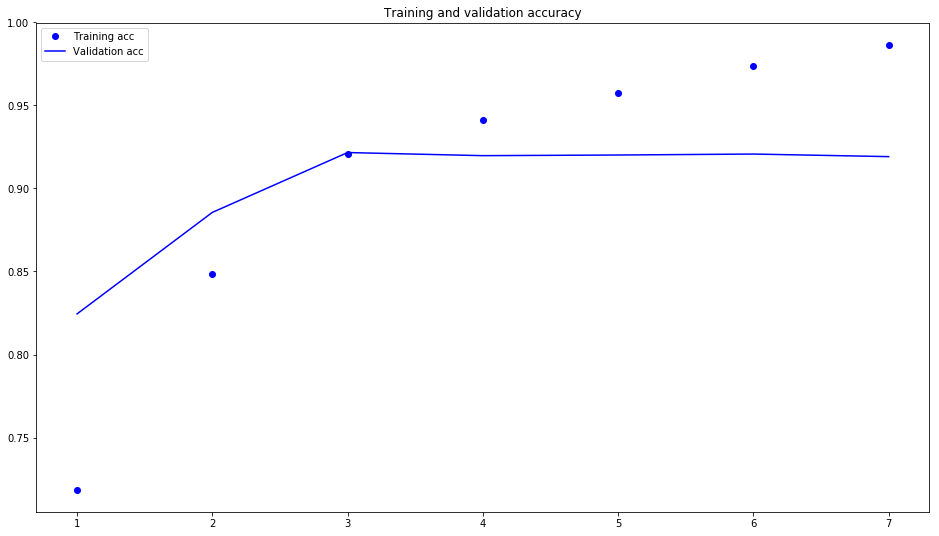

In [9]:
acc = history.history['aux_output_acc']
val_acc = history.history['val_aux_output_acc']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

Now, we can take the auxiliary data and play with it. Theres 16 columns, thats quite a lot, maybe do PCA with it?

In [10]:
# put training/ val through model
Ptrain = model.predict(train)
Pvec = model.predict(val)
# take just the aux stuff
T = Ptrain[1]
V = Pvec[1]
# lets try reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(T)
pca.n_components_

3

In [11]:
# do the transform: 32 -> 3
Ptr = pca.transform(T)
Pv = pca.transform(V)

In [12]:
#check to see if its all good
svc = svm.SVC(decision_function_shape='ovo', kernel='linear',probability=True)
SVC = svc.fit(Ptr, inspire_train['Result'])

print SVC.score(Pv, inspire_val['Result'])

0.917203608247


build a new df

In [13]:
#put the 3 PC columns into original df's
PCA_ = ['PC1', 'PC2', 'PC3']
training = pd.DataFrame(Ptr, columns=PCA_)
inspire_train = pd.concat([inspire_train, training], axis = 1)

vali = pd.DataFrame(Pv, columns=PCA_)
inspire_val   = pd.concat([inspire_val, vali], axis = 1)

## SVM 

In [155]:
# quick check of quality
#inputs = ['Title-sing', 'Title-bi', 'Title-tri', 'Title-quad', 'Abs-sing','Abs-bi', 'Abs-tri', 'Abs-quad','core refs', 'non-core refs', 'PC1', 'PC2', 'PC3']
#inputs = ['core refs', 'non-core refs', 'PC1', 'PC2', 'PC3']
inputs = ['core refs', 'non-core refs']

svc = svm.SVC(decision_function_shape='ovo', kernel='linear', C=615, probability=True)
SVC = svc.fit(inspire_train[inputs], inspire_train['Result'])
print SVC.score(inspire_val[inputs], inspire_val['Result'])

0.897615979381


In [15]:
dec = svc.decision_function(inspire_val[inputs])
print dec

[[ 0.11675777  1.42468874  1.65707084]
 [ 0.7847575   1.57426244  1.38171964]
 [ 1.42736009  1.71814939  1.11683721]
 ..., 
 [ 1.71056017  1.78156152  1.00010141]
 [ 1.71056017  1.78156152  1.00010141]
 [-3.6871059  -6.8132135  -4.15018392]]


In [16]:
class_probabilities = svc.predict_proba(inspire_val[inputs])
print class_probabilities[7735]

[ 0.97033386  0.023044    0.00662214]


scores

In [20]:
X = inspire_train[inputs]
y = inspire_train['Result']

#svc = svm.SVC(kernel='linear')
#svc = svm.SVC(decision_function_shape='ovo')

C_s = np.logspace(-1, 3, 20)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0.7, 1 )
plt.show()

KeyboardInterrupt: 

In [34]:
from sklearn.model_selection import GridSearchCV, cross_val_score
Cs = np.logspace(-1, 3, 20)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs), n_jobs=-1)

clf.fit(inspire_train[inputs], inspire_train['Result']) 

print clf.best_score_ 
print clf.best_estimator_.C  

KeyboardInterrupt: 

Confusion Matrix

0.923840206186
Normalized confusion matrix
[[ 0.99  0.01  0.  ]
 [ 0.58  0.32  0.1 ]
 [ 0.11  0.04  0.84]]


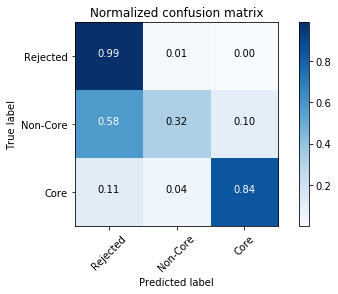

In [17]:
class_names = ["Rejected", "Non-Core", "Core"]

X_test = inspire_val[inputs]
y_test = inspire_val['Result']

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
# classifier = svm.SVC(decision_function_shape='ovo', C=clf.best_estimator_.C)

#classifier = svm.SVC(decision_function_shape='ovo', class_weight='balanced', C=1)
y_pred = svc.predict(X_test)
print SVC.score(X_test, y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Look for wrongly labelled Non-core things

In [21]:
print y_pred.shape

y_pred.reshape(15520,1)
inspire_val['y_pred'] = y_pred

def make_List(Actual, Prediction):
    A1 = inspire_val.loc[(inspire_val['Result'] == Actual) ]   #truly non-core
    out = A1.loc[(A1['y_pred'] == Prediction)]  
    return out

(15520,)


In [227]:
print class_probabilities[7704]

[ 0.97  0.02  0.01]


In [31]:
col = ['Text', 'Category', 'Result', 'y_pred']

wrong_NC = make_List(1,0)[col].reset_index(drop=True) 
true_Rej = make_List(0,0)[col].reset_index(drop=True) 

In [48]:
# tokenise the words, try find the most "non-core-y" ones
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def List_of_words(TEXT, num):
    features=[]
    lectures = TEXT['Text']
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(lectures)

    indices = np.argsort(vectorizer.idf_)[::-1]
    features = vectorizer.get_feature_names()

    top_n = num
    top_features = [features[i] for i in indices[:top_n]]
    return top_features

In [226]:
wrong_nc = List_of_words(wrong_NC, 10000)
true_rej = List_of_words(true_Rej, 50000)

intercept = list( set(wrong_nc).intersection( set(true_rej) ) )

In [227]:
new_wrong_nc = list( (set(wrong_nc).symmetric_difference(set(intercept))))

In [266]:
len (wrong_nc), len(intercept), len(new_wrong_nc)

(9704, 8058, 1646)

In [267]:
Wrong_NC = [x for x in new_wrong_nc if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]

In [253]:
import csv

with open('Wrong_NC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL, delimiter='\n')
    wr.writerow(Wrong_NC)

In [282]:
print list( (set(Wrong_NC).intersection(set(true_Rej['Text'][6].split(' ')))))

[]


In [273]:
'kiloelectronvolts' in true_rej

False

In [39]:
#load up the original dictionary
keysfile = np.loadtxt("KeyWords.csv", dtype="str") # load the keywords.
keywords = [word.lower() for word in keysfile]     # lowercase them all.

In [40]:
#how many words in original dictionary and "new dictionary"
len(list( set(wrong_nc).intersection( set(keywords)) ) )

59